In [ ]:
"""A medical image analysis pipeline.

The pipeline is used for brain tissue segmentation using a decision forest classifier.
"""
clear: all

In [1]:
import argparse
import datetime
import os
import sys
import timeit
import warnings
import pickle
import itertools

import SimpleITK as sitk
import sklearn.ensemble as sk_ensemble
import numpy as np
import pymia.data.conversion as conversion
import pymia.evaluation.writer as writer

sys.argv = ['']

try:
    import mialab.data.structure as structure
    import mialab.utilities.file_access_utilities as futil
    import mialab.utilities.pipeline_utilities as putil
except ImportError:
    # Append the MIALab root directory to Python path
    print(os.path.dirname(sys.argv[0]), '..')
    sys.path.insert(0, '/storage/homefs/lr13y079/MIALab/MIALab-master')
    import mialab.data.structure as structure
    import mialab.utilities.file_access_utilities as futil
    import mialab.utilities.pipeline_utilities as putil

LOADING_KEYS = [structure.BrainImageTypes.T1w,
                structure.BrainImageTypes.T2w,
                structure.BrainImageTypes.GroundTruth,
                structure.BrainImageTypes.BrainMask,
                structure.BrainImageTypes.RegistrationTransform]  # the list of data we will load


def main(result_dir: str, data_atlas_dir: str, data_train_dir: str, data_test_dir: str):
    """Brain tissue segmentation using decision forests.

    The main routine executes the medical image analysis pipeline:

        - Image loading
        - Registration
        - Pre-processing
        - Feature extraction
        - Decision forest classifier model building
        - Segmentation using the decision forest classifier model on unseen images
        - Post-processing of the segmentation
        - Evaluation of the segmentation
    """
    # all the combinations of removing one or two elements from a list of seven 
    # --> 0,1,2: atlas coordinates feature   3,4: intensity features (T1,T2)   5,6: gradient magnitude features (T1,T2)
    feature_to_del = list(itertools.combinations(list(range(0,7)), 2)) + list(itertools.combinations(list(range(0,7)), 1))
    
    
    result_dir_master = result_dir
    for fdel in feature_to_del:
        print('features removed: {}'.format(fdel))
        result_dir = result_dir_master
        
        # load atlas images
        putil.load_atlas_images(data_atlas_dir)

        print('-' * 5, 'Training...')

        # crawl the training image directories
        crawler = futil.FileSystemDataCrawler(data_train_dir,
                                              LOADING_KEYS,
                                              futil.BrainImageFilePathGenerator(),
                                              futil.DataDirectoryFilter())
        pre_process_params = {'skullstrip_pre': True,
                              'normalization_pre': True,
                              'registration_pre': True,
                              'coordinates_feature': True,
                              'intensity_feature': True,
                              'gradient_intensity_feature': True}
        
        '''
        # load images for training and pre-process
        images = putil.pre_process_batch(crawler.data, pre_process_params, multi_process=False)
       
        
        with open('images.pkl', 'wb') as file:
            # A new file will be created
            pickle.dump(images, file)
        '''
    
        with open('images.pkl', 'rb') as file:

            # Call load method to deserialze
            images = pickle.load(file)
        
        # delete features from feature_matrices of all pre-processed training images
        print(images[0].feature_matrix[0])
        break
        for img in images:
            img.feature_matrix = (np.delete(img.feature_matrix[0], fdel, 1), img.feature_matrix[1])

        # generate feature matrix and label vector
        data_train = np.concatenate([img.feature_matrix[0] for img in images])
        labels_train = np.concatenate([img.feature_matrix[1] for img in images]).squeeze()

        #warnings.warn('Random forest parameters not properly set.')
        forest = sk_ensemble.RandomForestClassifier(max_features=images[0].feature_matrix[0].shape[1], n_estimators=10, max_depth=10)

        start_time = timeit.default_timer()
        forest.fit(data_train, labels_train)
        print(' Time elapsed:', timeit.default_timer() - start_time, 's')

        # create a result directory with timestamp
        t = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S_feature_deleted_{}'.format(fdel))
        print(t)
        result_dir = os.path.join(result_dir, t)
        os.makedirs(result_dir, exist_ok=True)

        print('-' * 5, 'Testing...')

        # initialize evaluator
        evaluator = putil.init_evaluator()
        print('evaluator')

        # crawl the training image directories
        crawler = futil.FileSystemDataCrawler(data_test_dir,
                                              LOADING_KEYS,
                                              futil.BrainImageFilePathGenerator(),
                                              futil.DataDirectoryFilter())
        print('crawler')
        # load images for testing and pre-process
        pre_process_params['training'] = False
        images_test = putil.pre_process_batch(crawler.data, pre_process_params, multi_process=False)
    
         # delete features from feature_matrices of all pre-processed testing images
        for img in images_test:
            img.feature_matrix = (np.delete(img.feature_matrix[0], fdel, 1), img.feature_matrix[1])
    
        images_prediction = []
        images_probabilities = []
    
        for img in images_test:
            print(len(images_test))
            print('-' * 10, 'Testing', img.id_)

            start_time = timeit.default_timer()
            predictions = forest.predict(img.feature_matrix[0])
            probabilities = forest.predict_proba(img.feature_matrix[0])
            print(' Time elapsed:', timeit.default_timer() - start_time, 's')

            # convert prediction and probabilities back to SimpleITK images
            image_prediction = conversion.NumpySimpleITKImageBridge.convert(predictions.astype(np.uint8),
                                                                        img.image_properties)
            image_probabilities = conversion.NumpySimpleITKImageBridge.convert(probabilities, img.image_properties)

            # evaluate segmentation without post-processing
            evaluator.evaluate(image_prediction, img.images[structure.BrainImageTypes.GroundTruth], img.id_)

            images_prediction.append(image_prediction)
            images_probabilities.append(image_probabilities)

        # post-process segmentation and evaluate with post-processing
        post_process_params = {'simple_post': True}
        images_post_processed = putil.post_process_batch(images_test, images_prediction, images_probabilities,
                                                         post_process_params, multi_process=True)

        for i, img in enumerate(images_test):
            evaluator.evaluate(images_post_processed[i], img.images[structure.BrainImageTypes.GroundTruth],
                               img.id_ + '-PP')

            # save results
            sitk.WriteImage(images_prediction[i], os.path.join(result_dir, images_test[i].id_ + '_SEG.mha'), True)
            sitk.WriteImage(images_post_processed[i], os.path.join(result_dir, images_test[i].id_ + '_SEG-PP.mha'), True)

        # use two writers to report the results
        os.makedirs(result_dir, exist_ok=True)  # generate result directory, if it does not exists
        result_file = os.path.join(result_dir, 'results.csv')
        writer.CSVWriter(result_file).write(evaluator.results)

        print('\nSubject-wise results...')
        writer.ConsoleWriter().write(evaluator.results)

        # report also mean and standard deviation among all subjects
        result_summary_file = os.path.join(result_dir, 'results_summary.csv')
        functions = {'MEAN': np.mean, 'STD': np.std}
        writer.CSVStatisticsWriter(result_summary_file, functions=functions).write(evaluator.results)
        print('\nAggregated statistic results...')
        writer.ConsoleStatisticsWriter(functions=functions).write(evaluator.results)

        # clear results such that the evaluator is ready for the next evaluation
        evaluator.clear()


if __name__ == "__main__":
    """The program's entry point."""

    script_dir = os.path.dirname(sys.argv[0])
    #script_dir = '/storage/homefs/lr13y079/MIALab/MIALab-master'
    print(script_dir)

    parser = argparse.ArgumentParser(description='Medical image analysis pipeline for brain tissue segmentation')

    parser.add_argument(
        '--result_dir',
        type=str,
        default=os.path.normpath(os.path.join(script_dir, './mia-result')),
        help='Directory for results.'
    )

    parser.add_argument(
        '--data_atlas_dir',
        type=str,
        default=os.path.normpath(os.path.join(script_dir, '../data/atlas')),
        help='Directory with atlas data.'
    )

    parser.add_argument(
        '--data_train_dir',
        type=str,
        default=os.path.normpath(os.path.join(script_dir, '../data/train/')),
        help='Directory with training data.'
    )

    parser.add_argument(
        '--data_test_dir',
        type=str,
        default=os.path.normpath(os.path.join(script_dir, '../data/test/')),
        help='Directory with testing data.'
    )

    args = parser.parse_args()
    main(args.result_dir, args.data_atlas_dir, args.data_train_dir, args.data_test_dir)
    

 ..

features removed: (0, 1)
----- Training...
[[-66.0 113.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [1.0 112.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [-29.0 100.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [11.0 94.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [24.0 61.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [22.0 55.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [2.0 51.0 -72.0 2.1258621215820312 1.3581053018569946 1.5875188112258911
  0.911041259765625]
 [-90.0 -13.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [11.0 -28.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [-80.0 -61.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [-37.0 -62.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [-31.0 -76.0 -72.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [-85.0 122.0 -71.0 -0.4931284189224243 -0.4835553467273712 0.0 0.0]
 [40.0 82.0 -71.0 -0.4931284189224243 

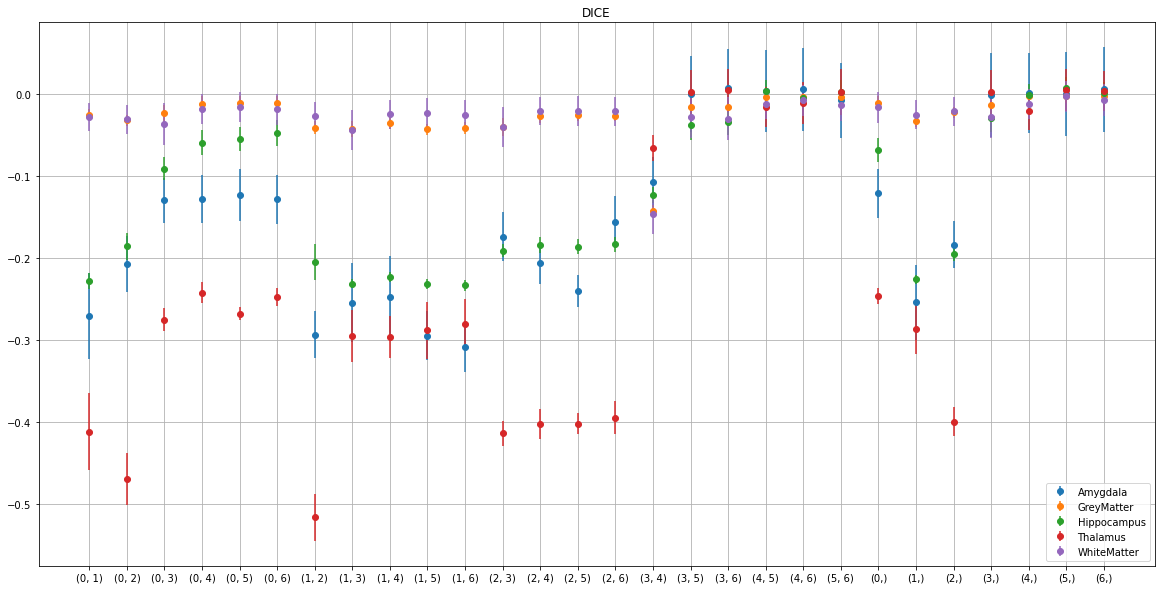

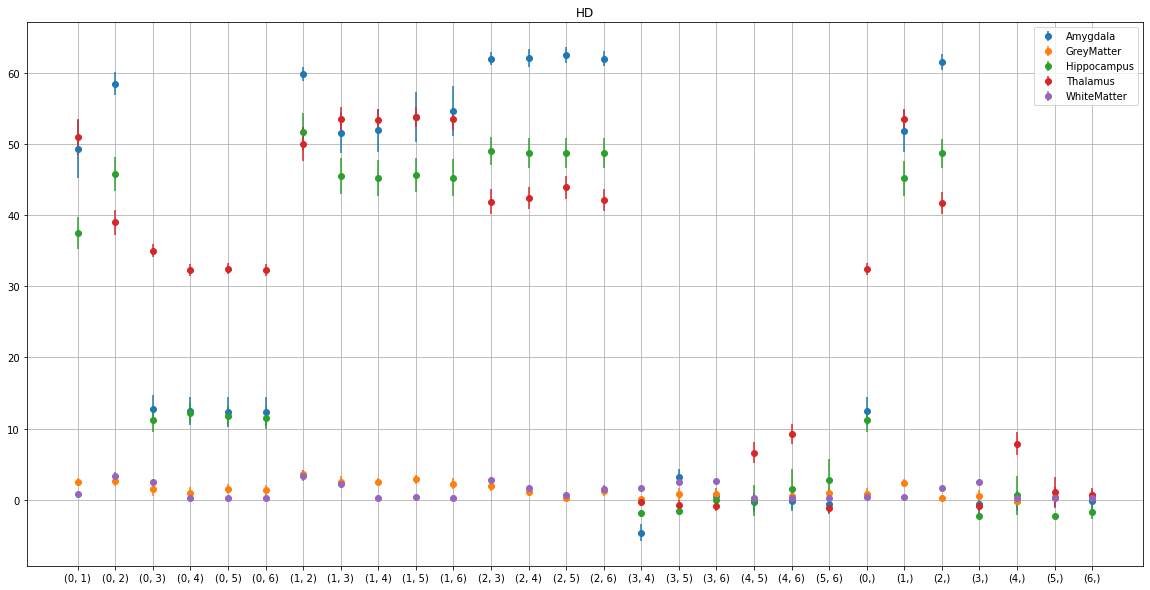

In [4]:
# plot results
import os
import csv
import itertools
import functools
import operator
import numpy as np
import matplotlib.pyplot as plt

Amygdala = np.zeros((4, 29))
GreyMatter = np.zeros((4, 29))
Hippocampus = np.zeros((4, 29))
Thalamus = np.zeros((4, 29))
WhiteMatter = np.zeros((4, 29))
    

files = sorted(os.listdir('/storage/homefs/lr13y079/MIALab/MIALab-master/bin/mia-result'))
files = [item for item in files if any(ele in item for ele in ['2022'])]
for idx, folder in enumerate(files):
    path = os.path.join('/storage/homefs/lr13y079/MIALab/MIALab-master/bin/mia-result', folder, 'results_summary.csv')
    with open(path, newline='') as csvfile:
        reader = list(csv.reader(csvfile, delimiter=';'))
        for n in range(4):
            Amygdala[n][idx] = reader[n + 1][3]
            GreyMatter[n][idx] = reader[n + 5][3]
            Hippocampus[n][idx] = reader[n + 9][3]
            Thalamus[n][idx] = reader[n + 13][3]
            WhiteMatter[n][idx] = reader[n + 17][3]
        
Amygdala[0][1:29] = Amygdala[0][1:29] - Amygdala[0][0] 
GreyMatter[0][1:29] = GreyMatter[0][1:29] - GreyMatter[0][0]
Hippocampus[0][1:29] = Hippocampus[0][1:29] - Hippocampus[0][0]
Thalamus[0][1:29] = Thalamus[0][1:29] - Thalamus[0][0]
WhiteMatter[0][1:29] = WhiteMatter[0][1:29] - WhiteMatter[0][0]
Amygdala[2][1:29] = Amygdala[2][1:29] - Amygdala[2][0] 
GreyMatter[2][1:29] = GreyMatter[2][1:29] - GreyMatter[2][0]
Hippocampus[2][1:29] = Hippocampus[2][1:29] - Hippocampus[2][0]
Thalamus[2][1:29] = Thalamus[2][1:29] - Thalamus[2][0]
WhiteMatter[2][1:29] = WhiteMatter[2][1:29] - WhiteMatter[2][0]

            
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(range(28), Amygdala[0][1:29], Amygdala[1][1:29], fmt='o', label='Amygdala')
plt.errorbar(range(28), GreyMatter[0][1:29], GreyMatter[1][1:29], fmt='o', label='GreyMatter')
plt.errorbar(range(28), Hippocampus[0][1:29], Hippocampus[1][1:29], fmt='o', label='Hippocampus')
plt.errorbar(range(28), Thalamus[0][1:29], Thalamus[1][1:29], fmt='o', label='Thalamus')
plt.errorbar(range(28), WhiteMatter[0][1:29], WhiteMatter[1][1:29], fmt='o', label='WhiteMatter')
plt.legend(loc='lower right')
plt.xticks(range(0,28))
ax.set_xticklabels(list(itertools.combinations(list(range(0,7)), 2)) + list(itertools.combinations(list(range(0,7)), 1)))
plt.title('DICE')
plt.grid(which='major', axis='both')
plt.show()

fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = (20,10)
plt.errorbar(range(28), Amygdala[2][1:29], Amygdala[3][1:29], fmt='o', label='Amygdala')
plt.errorbar(range(28), GreyMatter[2][1:29], GreyMatter[3][1:29], fmt='o', label='GreyMatter')
plt.errorbar(range(28), Hippocampus[2][1:29], Hippocampus[3][1:29], fmt='o', label='Hippocampus')
plt.errorbar(range(28), Thalamus[2][1:29], Thalamus[3][1:29], fmt='o', label='Thalamus')
plt.errorbar(range(28), WhiteMatter[2][1:29], WhiteMatter[3][1:29], fmt='o', label='WhiteMatter')
plt.legend(loc='upper right')
plt.xticks(range(0,28))
ax.set_xticklabels(list(itertools.combinations(list(range(0,7)), 2)) + list(itertools.combinations(list(range(0,7)), 1)))
plt.title('HD')
plt.grid(which='major', axis='both')
plt.show()

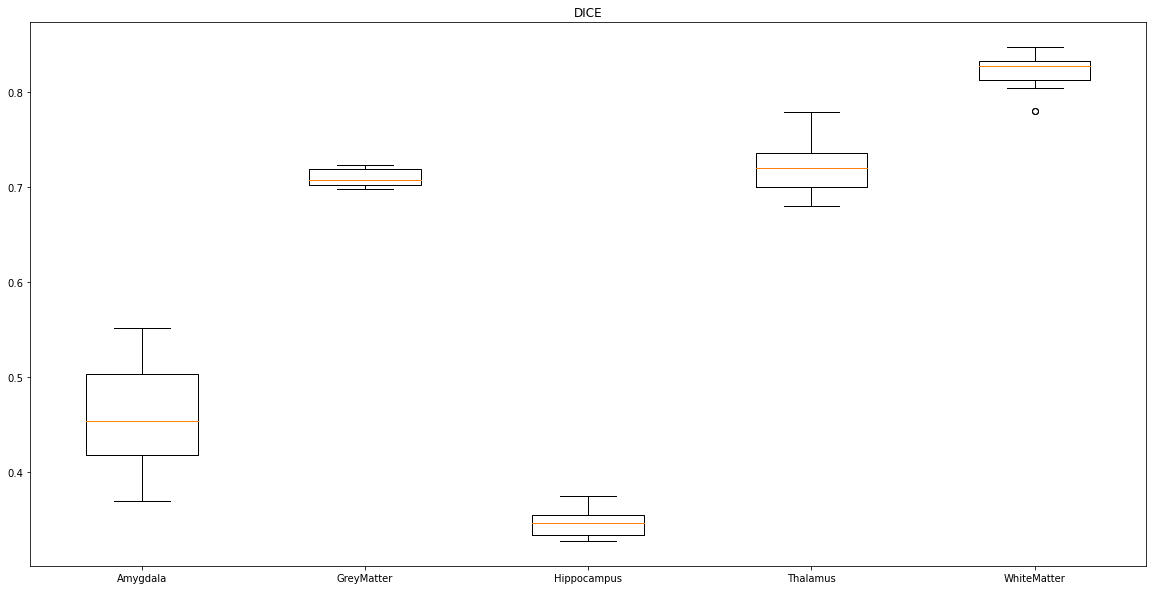

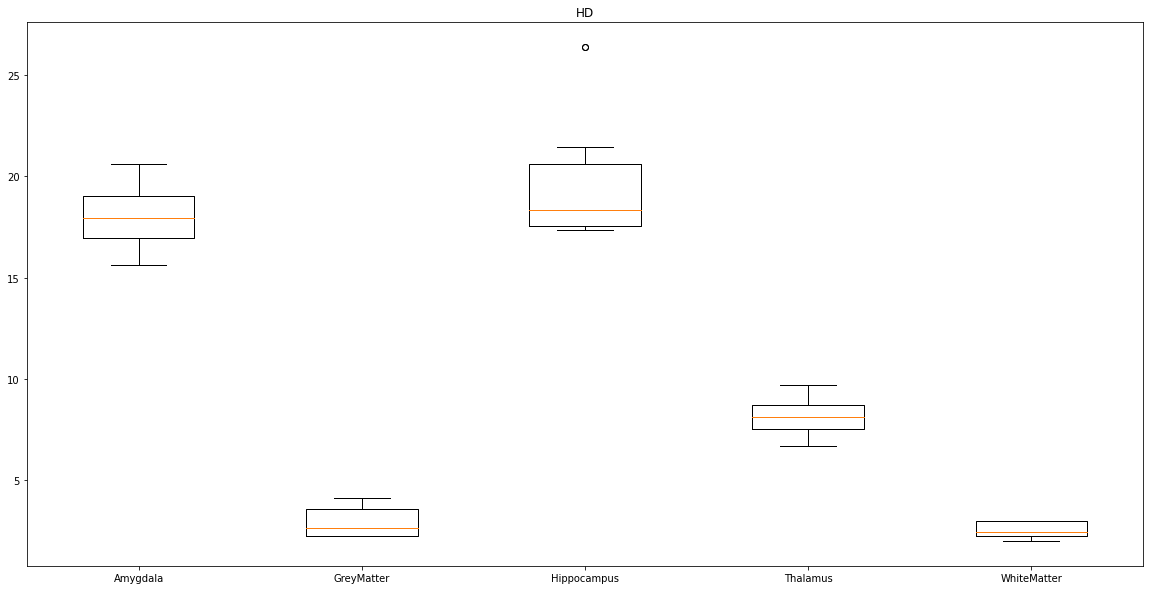

In [7]:
# boxplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


def main():
    # todo: load the "results.csv" file from the mia-results directory
    # todo: read the data into a list
    # todo: plot the Dice coefficients per label (i.e. white matter, gray matter, hippocampus, amygdala, thalamus)
    #  in a boxplot

    # alternative: instead of manually loading/reading the csv file you could also use the pandas package
    # but you will need to install it first ('pip install pandas') and import it to this file ('import pandas as pd')

    data = pd.read_csv('/storage/homefs/lr13y079/MIALab/MIALab-master/bin/mia-result/2022-10-29-18-33-01/results.csv')
    data = data.values.tolist()

    results = []
    for i in range(len(data)):
        a = data[i]
        a = a[0].split(';')
        results.append(a)


    DICE = np.zeros((math.floor(len(data)/5),5))
    HD = np.zeros((math.floor(len(data)/5),5))

    for i in range(len(data)):
        DICE[math.floor(i/5)][i%5] = results[i][2]
        HD[math.floor(i/5)][i%5] = results[i][3]


    fig1, ax = plt.subplots()
    ax.set_title('DICE')
    ax.boxplot(DICE)
    plt.xticks([1, 2, 3, 4, 5], ['Amygdala', 'GreyMatter', 'Hippocampus', 'Thalamus', 'WhiteMatter'])

    plt.show()

    fig2, ax = plt.subplots()
    ax.set_title('HD')
    ax.boxplot(HD)
    plt.xticks([1, 2, 3, 4, 5], ['Amygdala', 'GreyMatter', 'Hippocampus', 'Thalamus', 'WhiteMatter'])

    plt.show()



if __name__ == '__main__':
    main()
                
                